In [145]:
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [146]:
file_path = 'cluster_new_raw_test.csv'
df = pd.read_csv(file_path)
df.drop(columns=['id'], inplace=True)
df.head()

,EDA,TEMP,BVP,HR,Cluster
0,0.563729,4.00,64.0,1.00,0
1,-0.000000,33.99,-0.0,83.00,0
2,0.382858,33.99,-0.0,83.00,1
3,0.438379,33.99,-0.0,75.33,1
4,0.414428,33.99,-0.0,70.50,1


In [147]:
y = df['Cluster']
y.value_counts()


Cluster
0    240871
1    210399
Name: count, dtype: int64

<Axes: >

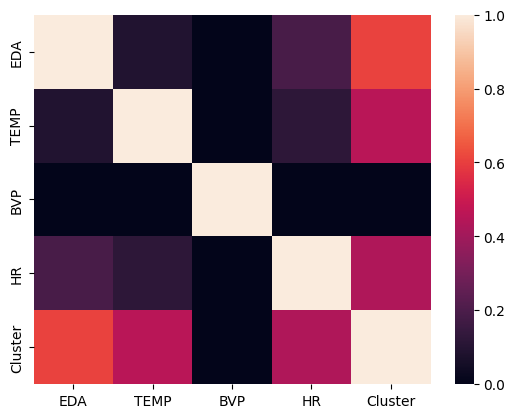

In [148]:
sns.heatmap(df.corr())

In [160]:
import dask.dataframe as dd
import dask.array as da
from dask_ml.linear_model import LogisticRegression
from dask_ml.model_selection import train_test_split, GridSearchCV
from dask_ml.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [ ]:
# Load large dataset with Dask
# Replace 'your_large_dataset.csv' with the actual file path
# df = dd.read_csv(file_path)
# converting pandas datafram to dask dataframe
df = dd.from_pandas(df, npartitions=3)
# Inspect the dataset (optional)
df.head()

,EDA,TEMP,BVP,HR,Cluster
0,0.563729,4.00,64.0,1.00,0
1,-0.000000,33.99,-0.0,83.00,0
2,0.382858,33.99,-0.0,83.00,1
3,0.438379,33.99,-0.0,75.33,1
4,0.414428,33.99,-0.0,70.50,1


In [151]:
# raw_data = df.drop('id', axis=1)

# # conversion to pandas
# df = raw_data.compute()

In [152]:
df.head()

,EDA,TEMP,BVP,HR,Cluster
0,0.563729,4.00,64.0,1.00,0
1,-0.000000,33.99,-0.0,83.00,0
2,0.382858,33.99,-0.0,83.00,1
3,0.438379,33.99,-0.0,75.33,1
4,0.414428,33.99,-0.0,70.50,1


In [153]:
# Assume 'target' is the target variable and others are features
target_column = 'Cluster'
X = df.drop(columns=[target_column]).to_dask_array(lengths=True)
y = df[target_column].to_dask_array(lengths=True)

In [154]:
# Apply standardization
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [155]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [156]:
X_train.shape, X_test.shape

((338452, 4), (112818, 4))

In [157]:
# Create and train the logistic regression model
# You can tune hyperparameters like 'max_iter' and 'penalty'
# model = LogisticRegression(solver="admm", max_iter=1000)
model = LogisticRegression(penalty='l2', C=1.0)

# Train the model (fit the data)
model.fit(X_train, y_train)


LogisticRegression()

In [158]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Compute accuracy (convert Dask arrays to NumPy for metrics)
accuracy = accuracy_score(y_test.compute(), y_pred.compute())
print(f"Accuracy: {accuracy}")

Accuracy: 0.9011505256253435


### Hyperparameter tuning

In [188]:
#  Define a hyperparameter grid to search over
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2'],      # Regularization method
    'solver': ['gradient_descent', 'lbfgs', 'newton', 'proximal_grad', 'admm']  # Solvers to use
    # 'verbose': [2]
}

In [189]:
log_reg = LogisticRegression(max_iter=10000)

In [190]:
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# 6. Fit the grid search to the training data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000),
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2'],
                         'solver': ['gradient_descent', 'lbfgs', 'newton',
                                    'proximal_grad', 'admm']},
             scoring='accuracy')

In [191]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best hyperparameters:", best_params)
print("Best cross-validation score: {:.4f}".format(best_score))

Best hyperparameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validation score: 0.8962


In [193]:
#  Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

from sklearn.metrics import classification_report
# Print classification report for the test set
print("\nClassification Report on Test Data:")
print(classification_report(y_test, y_pred))


Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     60218
           1       0.89      0.90      0.90     52600

    accuracy                           0.90    112818
   macro avg       0.90      0.90      0.90    112818
weighted avg       0.91      0.90      0.91    112818

